Домашнее задание:

- К вам приходит руководитель продукта “Интернет-магазин”
- И спрашивает про удержание клиентов и повторные покупки
- У него есть опасение, что из-за проблем с доставкой товаров в магазине у нас стали больше оттекать пользователи
- Он просит вас сравнить, на сколько сейчас все хуже, чем в прошлом году? 

Данные лежат в папке занятия на сервере:

- есть транзакции (покупки) в интернет магазине, в том числе id клиента, id покупки, timestamp покупки и тп
- orders.csv, customers.csv


Ваши задачи: 

- Проверить гипотезу руководителя продукта 
- Дать руководителю продукта инструмент для самостоятельного принятия решений по качеству удержания пользовательской базы
Ответ может быть в любом формате 

ДЕДЛАЙН: до 23:59 02.02.2022

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
#Заказы
orders =  pd.read_csv('orders.csv', encoding="ISO-8859-1")

In [3]:
#Покупатели
customers =  pd.read_csv('customers.csv', encoding="ISO-8859-1")

In [4]:
#Объединяем таблицы
order_and_customers=orders.merge(customers, left_on='customer_id', right_on='id').drop(columns=['id_y'])

In [5]:
#Удаляем дубликаты
order_and_customers.drop_duplicates(inplace=True)

In [6]:
#Проверяем уникальность чеков
len(order_and_customers['id_x'].unique())

5009

In [7]:
#Удаляем данные с нулевыми id или нулевой стоимостью покупки
order_and_customers=order_and_customers[(order_and_customers.id_x.notnull()) & (order_and_customers.sales!=0)]

In [8]:
#Делаем колонку с датой типа даты, делаем колонку с год-месяц покупки
order_and_customers['order_date'] = pd.to_datetime(order_and_customers['order_date'], infer_datetime_format=True)
order_and_customers['Y_m'] = order_and_customers['order_date'].dt.strftime('%Y-%m') 

In [9]:
#Находим дату первой покупки для разделения пользователеей на когорты
cohorts = order_and_customers.groupby('customer_id',as_index=False)['Y_m'].min()
cohorts.rename(columns = {'Y_m':'Cohort'},inplace=True)

In [10]:
#Добавляме информацию о когортах в общую таблицу
order_and_customers_cohorted = pd.merge(order_and_customers, cohorts, on='customer_id')
order_and_customers_cohorted

,id_x,order_date,ship_mode,customer_id,sales,name,segment,state,city,Y_m,Cohort
0,100006,2014-09-07,Standard,DK-13375,377.970,Dennis Kane,Consumer,Ohio,Marion,2014-09,2014-09
1,131884,2015-12-06,Same Day,DK-13375,594.002,Dennis Kane,Consumer,Ohio,Marion,2015-12,2014-09
2,145065,2015-12-12,First,DK-13375,32.308,Dennis Kane,Consumer,Ohio,Marion,2015-12,2014-09
3,133046,2017-07-27,Second,DK-13375,297.990,Dennis Kane,Consumer,Ohio,Marion,2017-07,2014-09
4,165099,2017-12-11,First,DK-13375,1.392,Dennis Kane,Consumer,Ohio,Marion,2017-12,2014-09
...,...,...,...,...,...,...,...,...,...,...,...
5004,168193,2017-03-06,Second,RM-19750,98.350,Roland Murray,Consumer,New York,New York City,2017-03,2017-03
5005,122140,2015-04-02,Standard,MO-17950,130.288,Michael Oakman,Consumer,Texas,Dallas,2015-04,2015-04
5006,166233,2017-07-03,Standard,MO-17950,24.000,Michael Oakman,Consumer,Texas,Dallas,2017-07,2015-04
5007,160150,2015-07-19,First,TS-21085,2.025,Thais Sissman,Consumer,Arizona,Phoenix,2015-07,2015-07


In [11]:
#Считаем сколько активных покупателей в каждой когорте было в определённый месяц
cohorts_group = order_and_customers_cohorted.groupby(
    ['Cohort', 'Y_m']).agg({'customer_id': pd.Series.nunique})

In [13]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df

In [14]:
#Производим преобразование таблицы
cohorts_group.rename(columns={'customer_id': 'TotalUsers'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['Cohort', 'CohortPeriod'], inplace=True) 

In [15]:
cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)

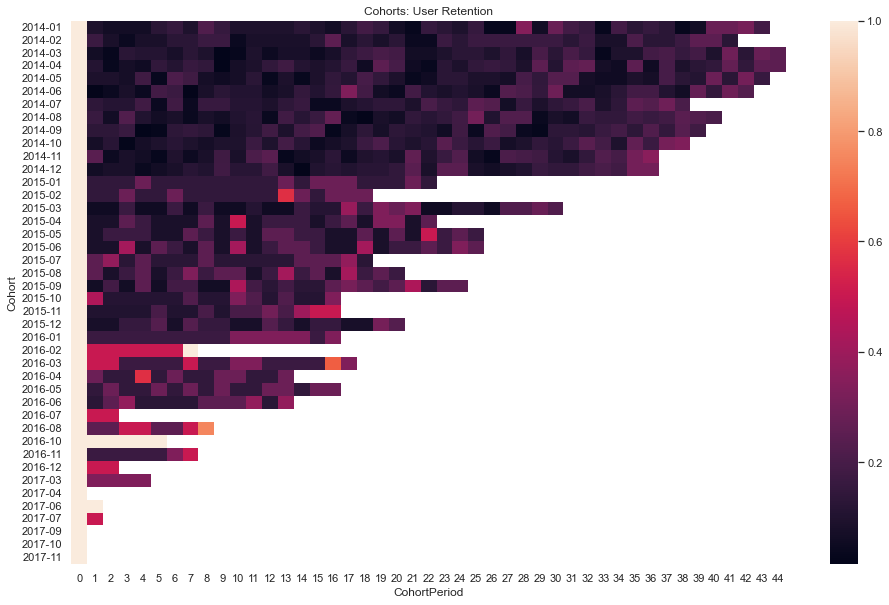

In [16]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull());

In [17]:
#По карте для когорт можно сказать, что людей недавно пришедшие к нам (в этом году), 
#стали реже оставаться у нас, однако на ранних периодах они стали активнее, чем раньше
#Покупатели пришедшие к нам в 2014 году всё ещё с нами и пользуются продуктом, в этом году даже чуть больше, чем обычно

In [19]:
order_and_customers['Y'] = order_and_customers['order_date'].dt.strftime('%Y') 
order_and_customers['m'] = order_and_customers['order_date'].dt.strftime('%m') 
months_data = order_and_customers.groupby(['Y', 'm']).agg({'customer_id': pd.Series.nunique})

In [20]:
#Находим дату первой покупки для разделения пользователеей на когорты
cohorts_year_only = order_and_customers.groupby('customer_id', as_index=False)['Y'].min()
cohorts_year_only.rename(columns = {'Y':'Cohort', 'customer_id': 'Total Users'}, inplace=True)

#Добавляме информацию о когортах в общую таблицу
order_and_customers_cohorted2 = pd.merge(order_and_customers, cohorts_year_only, left_on='customer_id', right_on='Total Users')
order_and_customers_cohorted2

#Считаем сколько активных покупателей в каждой когорте было в определённый месяц
cohorts_group2 = order_and_customers_cohorted2.groupby(
    ['Cohort', 'Y']).agg({'Total Users': pd.Series.nunique})

#Производим преобразование таблицы
cohorts_group2 = cohorts_group2.groupby(level=0).apply(cohort_period)
cohorts_group2.reset_index(inplace=True)
cohorts_group2.set_index(['Cohort', 'CohortPeriod'], inplace=True) 

user_retention2 = cohorts_group2['Total Users'].unstack(0)


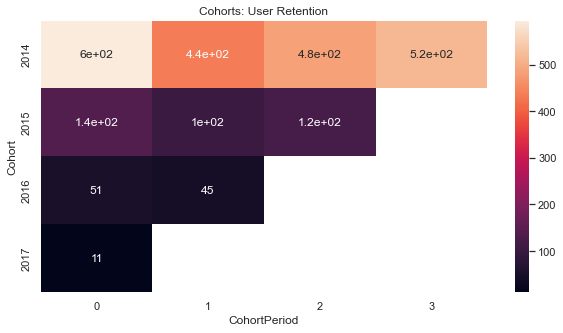

In [21]:
sns.set(style='white')
plt.figure(figsize=(10, 5))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention2.T, mask=user_retention2.T.isnull(), annot=True);

In [22]:
#Видим, что люди от года к году уходят с платформы несильно, но вот приходить на платформу стало меньше людей
#Возможно переживания руководителя продукта вызваны именно этим.

In [23]:
months_data=months_data['customer_id'].unstack(0)

In [24]:
months_data.columns

Index(['2014', '2015', '2016', '2017'], dtype='object', name='Y')

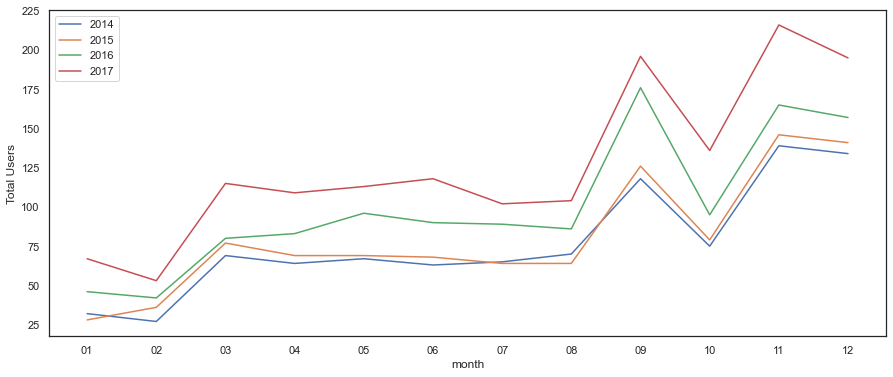

In [25]:
sns.set(style='white')
plt.figure(figsize=(15, 6))
for i in months_data.columns:
    splot=sns.lineplot(data=months_data, x='m', y=i)
splot.legend(['2014', '2015', '2016', '2017']);
splot.set(xlabel='month', ylabel='Total Users');

In [26]:
#График показывает, что ежемесячное количество покупателей за все годы выросло.
#Значит отток покупателей не привышает приток.

In [27]:
#Cмотрим, кто совершал покупки в этом году и в прошлом
separation_2017=order_and_customers[order_and_customers['Y']=='2017'].merge(
    cohorts_year_only, left_on='customer_id', right_on='Total Users')
separation_2016=order_and_customers[order_and_customers['Y']=='2016'].merge(
    cohorts_year_only, left_on='customer_id', right_on='Total Users')

In [28]:
separation_2017=separation_2017.groupby('Cohort').agg({'Total Users': pd.Series.nunique})
separation_2016=separation_2016.groupby('Cohort').agg({'Total Users': pd.Series.nunique})

In [29]:
print(separation_2017,separation_2016)

        Total Users
Cohort             
2014            517
2015            120
2016             45
2017             11         Total Users
Cohort             
2014            485
2015            102
2016             51


<AxesSubplot:title={'center':'Доля активных пользователй по годам регистрации в 2016'}, ylabel='Total Users'>

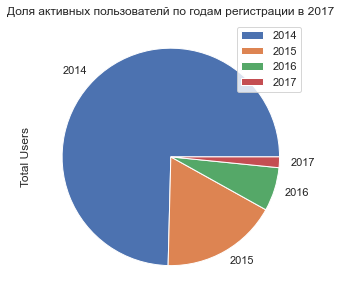

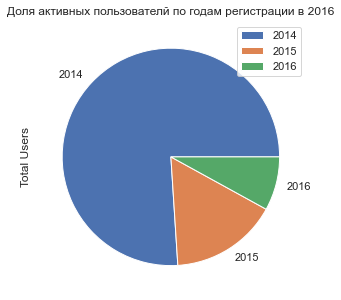

In [30]:
separation_2017.plot.pie(y='Total Users', figsize=(5, 5), title ='Доля активных пользователй по годам регистрации в 2017')
separation_2016.plot.pie(y='Total Users', figsize=(5, 5), title ='Доля активных пользователй по годам регистрации в 2016')

In [31]:
#Видим, что большая доля активных покупателей в этом году - старажилы, которые давно с нами, покупателей, привлечённых в
#в этом году мало. Видим, что есть тенденция к снижению числа привлеченных за год пользователей.

## Можно сделать вывод, что доживаемость людей действительно немного провисла, но скоре всего это связано с маленьким притоком людей на платформу. Старых покупателей мы хорошо удерживаем